In [1]:
%pip install jax

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/openface-0.3.2-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [3]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [4]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [5]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [6]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))
try:
  preds = predict(params, random_flattened_images)
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


In [7]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


In [8]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [9]:
import os
import gzip
import shutil
import numpy as np
import urllib.request
from urllib.error import URLError
from zipfile import ZipFile
from io import BytesIO
# URL for the MNIST dataset ZIP file
MNIST_ZIP_URL = 'https://data.deepai.org/mnist.zip'
def download_and_extract_mnist_zip(url, dest_folder):
    """Download and extract the MNIST ZIP file."""
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    zip_path = os.path.join(dest_folder, 'mnist.zip')
    try:
        urllib.request.urlretrieve(url, zip_path)
    except URLError as e:
        print(f"Failed to download the dataset. Error: {e}")
        return False
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)
    os.remove(zip_path)
    return True
def extract_gz_file(gz_path, dest_path):
    """Extract a .gz file."""
    with gzip.open(gz_path, 'rb') as f_in:
        with open(dest_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
def load_mnist_images(file_path):
    """Load MNIST images from the IDX file format."""
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 784)
def load_mnist_labels(file_path):
    """Load MNIST labels from the IDX file format."""
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data
# Define paths
data_folder = '/tmp/mnist_data'
train_images_path = os.path.join(data_folder, 'train-images-idx3-ubyte')
train_labels_path = os.path.join(data_folder, 'train-labels-idx1-ubyte')
test_images_path = os.path.join(data_folder, 't10k-images-idx3-ubyte')
test_labels_path = os.path.join(data_folder, 't10k-labels-idx1-ubyte')
# Download and extract the MNIST dataset
if download_and_extract_mnist_zip(MNIST_ZIP_URL, data_folder):
    # Extract .gz files
    extract_gz_file(train_images_path + '.gz', train_images_path)
    extract_gz_file(train_labels_path + '.gz', train_labels_path)
    extract_gz_file(test_images_path + '.gz', test_images_path)
    extract_gz_file(test_labels_path + '.gz', test_labels_path)
    # Load data
    train_images = load_mnist_images(train_images_path)
    train_labels = load_mnist_labels(train_labels_path)
    test_images = load_mnist_images(test_images_path)
    test_labels = load_mnist_labels(test_labels_path)
    # One-hot encoding of labels
    def one_hot(labels, num_classes):
        return np.eye(num_classes)[labels]
    num_labels = 10  # MNIST has 10 classes
    train_labels = one_hot(train_labels, num_labels)
    test_labels = one_hot(test_labels, num_labels)
    print("MNIST dataset successfully downloaded and processed.")
else:
    print("Failed to download and process the MNIST dataset.")



MNIST dataset successfully downloaded and processed.


In [10]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [11]:
import time
import numpy as np

def get_train_batches(batch_size):
    """Yield batches of train data."""
    num_samples = train_images.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # shuffle the indices for randomness

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield train_images[batch_indices], train_labels[batch_indices]

# Assuming you have defined num_epochs, batch_size, and update functions
for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in get_train_batches(batch_size):
        x = x.reshape(len(x), -1)  # Flatten the images if not already
        params = update(params, x, y)
    epoch_time = time.time() - start_time

    train_acc = accuracy(params, train_images.reshape(len(train_images), -1), train_labels)
    test_acc = accuracy(params, test_images.reshape(len(test_images), -1), test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))


Epoch 0 in 1.15 sec
Training set accuracy 0.9200000166893005
Test set accuracy 0.9205999970436096
Epoch 1 in 0.80 sec
Training set accuracy 0.9403166770935059
Test set accuracy 0.9414999485015869
Epoch 2 in 0.80 sec
Training set accuracy 0.9512166976928711
Test set accuracy 0.9483000040054321
Epoch 3 in 0.83 sec
Training set accuracy 0.9586333632469177
Test set accuracy 0.9544999599456787
Epoch 4 in 0.91 sec
Training set accuracy 0.9646833539009094
Test set accuracy 0.9587999582290649
Epoch 5 in 0.97 sec
Training set accuracy 0.9686999917030334
Test set accuracy 0.962399959564209
Epoch 6 in 1.04 sec
Training set accuracy 0.9713166952133179
Test set accuracy 0.9645999670028687
Epoch 7 in 0.85 sec
Training set accuracy 0.9758000373840332
Test set accuracy 0.9674999713897705
Epoch 8 in 0.89 sec
Training set accuracy 0.9776666760444641
Test set accuracy 0.9687999486923218
Epoch 9 in 0.89 sec
Training set accuracy 0.9776000380516052
Test set accuracy 0.9677000045776367


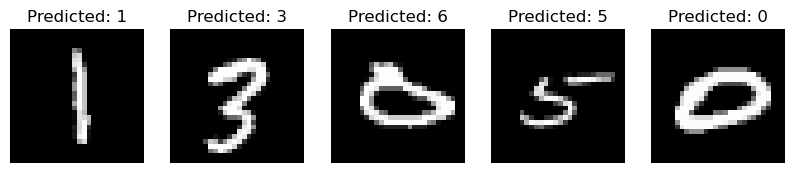

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder for the model's predict function
# Replace this with your actual model's prediction method

# Select five random test images
num_samples = 5
indices = np.random.choice(len(test_images), num_samples, replace=False)
selected_images = test_images[indices]
selected_labels = test_labels[indices]

# Generate predictions
# Replace 'model' with your actual model
predicted_labels = np.argmax(batched_predict(params, selected_images),axis=1)

# Visualize the images and the predictions
plt.figure(figsize=(10, 2))
for i, (image, label) in enumerate(zip(selected_images, predicted_labels)):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {label}')
    plt.axis('off')
plt.show()


## Next draw your own digits!

In [14]:
import tkinter as tk
from tkinter import Canvas
import numpy as np
from PIL import Image, ImageDraw

In [16]:
import tkinter as tk
from tkinter import Canvas
import numpy as np
from PIL import Image, ImageDraw


# Function to draw on the canvas
def draw(event):
    x, y = event.x, event.y
    canvas.create_oval((x, y, x + 10, y + 10), fill='black')
    draw_image.line([x, y, x + 1, y + 1], fill='black', width=10)

# Function to predict the digit
# def predict_digit():
#     canvas.postscript(file='digit.eps', colormode='color')
#     img = Image.open('digit.eps')
#     if img.mode not in ["RGB", "L"]:
#         img = img.convert("RGB")    
#     img = img.resize((28, 28), Image.Resampling.LANCZOS).convert('L')
#     img = np.array(img)
#     img = 1-img / 255.0

#     digit = np.argmax(predict(params,np.ndarray.flatten(img)))
#     label.config(text=str(digit))
import tkinter as tk
from tkinter import Canvas
import numpy as np
from PIL import Image, ImageDraw

# Function to predict the digit
def predict_digit():
    # Save the canvas drawing as an EPS file
    canvas.postscript(file='digit.eps', colormode='color')
    
    # Open EPS and save as PNG to avoid mode issues
    img = Image.open('digit.eps')
    img.save('digit.png', 'PNG')  # Convert to PNG first
    img = Image.open('digit.png')  # Reopen as PNG

    # Ensure correct mode before processing
    if img.mode not in ["RGB", "L"]:
        img = img.convert("RGB")

    # Resize and convert to grayscale ('L' mode)
    img = img.resize((28, 28), Image.LANCZOS).convert('L')

    # Convert to numpy array and normalize
    img = np.array(img)
    img = 1 - img / 255.0  # Normalize pixel values

    # Predict the digit
    digit = np.argmax(predict(params, np.ndarray.flatten(img)))
    label.config(text=str(digit))


# Function to clear the canvas and the image
def clear_canvas():
    canvas.delete("all")
    draw_image.rectangle((0, 0, 150, 150), fill='white')
    label.config(text="Draw a digit")

# Create the main window
root = tk.Tk()
root.title("Digit Predictor")

# Create a drawing canvas
canvas = Canvas(root, width=150, height=150, bg='white')
canvas.pack()

# PIL Image and Draw for capturing the drawn digit
image = Image.new("RGB", (150, 150), 'white')
draw_image = ImageDraw.Draw(image)

# Bind the drawing function to mouse drag
canvas.bind("<B1-Motion>", draw)

# Add a button to predict the digit
button_predict = tk.Button(root, text="Predict", command=predict_digit)
button_predict.pack()

# Add a button to clear the canvas
button_clear = tk.Button(root, text="Clear", command=clear_canvas)
button_clear.pack()

# Label to display the prediction
label = tk.Label(root, text="Draw a digit", font=("Helvetica", 16))
label.pack()

# Run the application
root.mainloop()

1. (1 point) How many layers are there in the neural network?
2. (1 point) What are the shapes of each parameter in "params"?
3. (2 points) Which activation function is used?
4. (2 points) What are the input space and label space?
5. (2 points) What does ``predict'' output?
6. (2 points) What are the training accuracy and test accuracy after 10 epochs? Use the GUI, write your 1,2,3,4,...,10 using your mouse.  Write a short report that shows your digits and the classification results.
7. (2 points) What is the classification accuracy on your data?  Is it better or worse than the accuracy on the test set?   If it is very different, could you explain why?  Any ideas to fix the issue?

# Discussion